## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [6]:
train_df = pd.read_parquet("train_data.pqt")
test_df = pd.read_parquet("test_data.pqt")
cluster_weights = pd.read_excel("cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

cat_cols = [
    "channel_code",
    "city",
    "city_type",
    "okved",
    "segment",
    "start_cluster",
    "index_city_code",
    "ogrn_month",
    "ogrn_year",
]

labels = [
    "{other}",
    "{}",
    "{α, β}",
    "{α, γ}",
    "{α, δ}",
    "{α, ε, η}",
    "{α, ε, θ}",
    "{α, ε, ψ}",
    "{α, ε}",
    "{α, η}",
    "{α, θ}",
    "{α, λ}",
    "{α, μ}",
    "{α, π}",
    "{α, ψ}",
    "{α}",
    "{λ}",
]

In [7]:
def extend_test(df):
    ddf = df.sort_values(by=["id", "date"], ascending=True)
    ddf.reset_index(drop=True, inplace=True)
    mask = (ddf["date"] == "month_5") & (ddf["date"].shift(1) == "month_6")
    rows_to_insert = df[mask].copy()
    rows_to_insert["date"] = "month_4"
    ddf = pd.concat([ddf, rows_to_insert], ignore_index=True)
    ddf = ddf.sort_values(by=["id", "date"], ascending=True)
    ddf.reset_index(drop=True, inplace=True)
    return ddf


def prepare_data_for_3m(
    df_train,
    df_test,
    cat_cols,
    nan_process="zero",
    drop_lot_nan_cols_thr=0.5,
):
    """
    Operations:
    1. fill na
    2. drop columns with too many nans

    df_train: pd.DataFrame
    df_test: pd.DataFrame
    nan_process: "zero" or "mean" or "median"
    drop_lot_nan_cols_thr: float, 0-1, 1 - no drop, 0 - drop all

    return: pd.DataFrame, pd.DataFrame, list

    """
    df_train["is_train"] = 1
    df_test["is_train"] = 0

    df_concat = pd.concat([df_train, df_test])
    bad_features = df_concat.columns[
        df_concat.isna().sum() > df_concat.shape[0] * drop_lot_nan_cols_thr
    ]

    if nan_process == "zero":
        df_concat = df_concat.fillna(-999)
    elif nan_process == "mean":
        df_concat = df_concat.fillna(df_concat.mean())
    elif nan_process == "median":
        df_concat = df_concat.fillna(df_concat.median())
    df_concat[cat_cols] = df_concat[cat_cols].astype("category")

    df_concat = df_concat.drop(bad_features, axis=1)
    df_train.drop("is_train", axis=1, inplace=True)
    df_test.drop("is_train", axis=1, inplace=True)

    return (
        df_concat[df_concat["is_train"] == 1].drop("is_train", axis=1),
        df_concat[df_concat["is_train"] == 0].drop(
            ["is_train", "end_cluster"], axis=1
        ),
        list(set(cat_cols).intersection(df_concat.columns)),
    )


def concatenate_months(df_train, df_test, cat_cols):
    """Concatenate data across months"""
    df_train = df_train.sort_values(by=["id", "date"], ascending=True)
    df_test = df_test.sort_values(by=["id", "date"], ascending=True)

    cat_cols_3 = (
        [f"{i}_1" for i in cat_cols]
        + [f"{i}_2" for i in cat_cols]
        + [f"{i}_3" for i in cat_cols]
    )

    concatenated_train = pd.DataFrame()
    concatenated_test = pd.DataFrame()

    concatenated_train["end_cluster"] = df_train["end_cluster"][
        df_train["date"] == "month_3"
    ].reset_index(drop=True)

    for i, month in enumerate(["month_1", "month_2", "month_3"]):
        data = (
            df_train[df_train["date"] == month]
            .drop(["date", "id", "end_cluster"], axis=1)
            .reset_index(drop=True)
        )
        data.columns = [f"{col}_{i+1}" for col in data.columns]
        concatenated_train = pd.concat([concatenated_train, data], axis=1)

    for i, month in enumerate(["month_4", "month_5", "month_6"]):

        data = (
            df_test[df_test["date"] == month]
            .drop(["date", "id"], axis=1)
            .reset_index(drop=True)
        )
        data.columns = [f"{col}_{i+1}" for col in data.columns]
        concatenated_test = pd.concat([concatenated_test, data], axis=1)

    assert concatenated_train.shape[1] == concatenated_test.shape[1] + 1
    assert (
        concatenated_train.columns[1:] == concatenated_test.columns
    ).sum() == concatenated_test.shape[1]
    return concatenated_train, concatenated_test, cat_cols_3

In [8]:
test_df = extend_test(test_df)
a, b, c = concatenate_months(train_df, test_df, cat_cols)
train_df_pr, test_df_pr, cat_cols_new = prepare_data_for_3m(a, b, c)

In [9]:
X = train_df_pr.drop(["end_cluster"], axis=1)
y = train_df_pr["end_cluster"]
x_train, x_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
x_train.shape

(160000, 261)

## Data analisis

Количество клиентов для которых start_cluster в 3 месяце не совпадает с предыдущими - 23702

## Model

In [13]:
def weighted_roc_auc(y_true, y_pred):
    global weights_dict
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(
        y_true, y_pred, labels=labels, multi_class="ovr", average=None
    )
    return sum(weights * classes_roc_auc), classes_roc_auc


class ITPurpleModel:
    def __init__(self, cat_cols, lr=0.1, iterations=100, depth=6):
        self.cat_cols = cat_cols
        self.help_cat_cols = list(set(cat_cols) - set(["start_cluster_3"]))
        self.lr = lr
        self.iterations = iterations
        self.depth = depth
        self.help_model = CatBoostClassifier(
            cat_features=self.help_cat_cols,
            iterations=iterations,
            depth=depth,
            learning_rate=lr,
            task_type="GPU",
            devices="0:1",
        )
        self.model = CatBoostClassifier(
            cat_features=cat_cols,
            iterations=iterations,
            depth=depth,
            learning_rate=lr,
            task_type="GPU",
            devices="0:1",
        )

    def fit(self, x_train, y_train, x_val, y_val):
        self.help_model.fit(
            x_train.drop("start_cluster_3", axis=1), x_train["start_cluster_3"]
        )
        self.model.fit(x_train, y_train)

        print("fitting done!")
        print(
            "Your roc_auc on train: ", self.weighted_roc_auc(x_train, y_train)
        )
        print("Your roc_auc on val: ", self.weighted_roc_auc(x_val, y_val))

    def predict_proba(self, x):
        mask = x["start_cluster_3"].isna()
        preds = self.help_model.predict_proba(x.drop("start_cluster_3", axis=1))
        x["start_cluster_3"] = np.array(
            [self.help_model.classes_[a.argmax()] for a in preds]
        )
        return self.model.predict_proba(x)

    def output_feature_importances(self):
        feature_importance = self.model.feature_importances_

        feature_importance_df = pd.DataFrame(
            {
                "Feature": self.model.feature_names_,
                "Importance": feature_importance,
            }
        )
        feature_importance_df = feature_importance_df.sort_values(
            by="Importance", ascending=False
        )
        return feature_importance_df

    def weighted_roc_auc(self, x, y):
        return weighted_roc_auc(y, self.predict_proba(x))

    def get_params(self, deep=True):
        return {
            "classes": self.model.classes_,
            "cat_cols": self.cat_cols,
            "lr": self.lr,
            "iterations": self.iterations,
            "depth": self.depth,
        }

    def visualize_importances(self, top=15):
        feature_importances = self.output_feature_importances().values
        sorted_feature_importances = feature_importances[
            feature_importances[:, 1].argsort()
        ][::-1]

        top_features = sorted_feature_importances[:top]

        feature_names = top_features[:, 0]
        importance_values = top_features[:, 1].astype(float)

        plt.figure(figsize=(10, 6))
        plt.barh(feature_names, importance_values, color="skyblue")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.title("Top 15 Most Important Features")
        plt.gca().invert_yaxis()
        plt.show()

    def export_importances_to_csv(self):
        feature_importances = self.output_feature_importances().values
        np.savetxt(
            "feature_impostances.csv",
            feature_importances,
            delimiter=",",
            fmt="%s",
        )

In [15]:
model = ITPurpleModel(cat_cols_new, iterations=1000, depth=8, lr=0.05)
model.fit(x_train, y_train, x_val, y_val)

model.output_feature_importances()

0:	learn: 1.8141293	total: 32.8ms	remaining: 32.8s
1:	learn: 1.5682644	total: 64.2ms	remaining: 32s
2:	learn: 1.3866248	total: 96.4ms	remaining: 32s
3:	learn: 1.2432582	total: 127ms	remaining: 31.7s
4:	learn: 1.1255550	total: 159ms	remaining: 31.6s
5:	learn: 1.0263367	total: 190ms	remaining: 31.6s
6:	learn: 0.9410976	total: 221ms	remaining: 31.4s
7:	learn: 0.8668048	total: 253ms	remaining: 31.3s
8:	learn: 0.8013221	total: 285ms	remaining: 31.4s
9:	learn: 0.7430804	total: 316ms	remaining: 31.3s
10:	learn: 0.6908913	total: 347ms	remaining: 31.2s
11:	learn: 0.6438354	total: 378ms	remaining: 31.1s
12:	learn: 0.6011822	total: 409ms	remaining: 31s
13:	learn: 0.5623454	total: 440ms	remaining: 31s
14:	learn: 0.5268443	total: 471ms	remaining: 30.9s
15:	learn: 0.4935035	total: 503ms	remaining: 31s
16:	learn: 0.4635152	total: 535ms	remaining: 31s
17:	learn: 0.4352318	total: 570ms	remaining: 31.1s
18:	learn: 0.4091425	total: 601ms	remaining: 31s
19:	learn: 0.3853926	total: 635ms	remaining: 31.1s
2

,Feature,Importance
187,okved_3,4.745898
173,start_cluster_2,4.045490
179,city_3,4.037667
260,start_cluster_3,3.875607
176,balance_amt_min_3,3.197734
...,...,...
132,cnt_days_cred_g_oper_1m_2,0.000000
6,city_type_1,0.000000
93,city_type_2,0.000000
92,city_2,0.000000


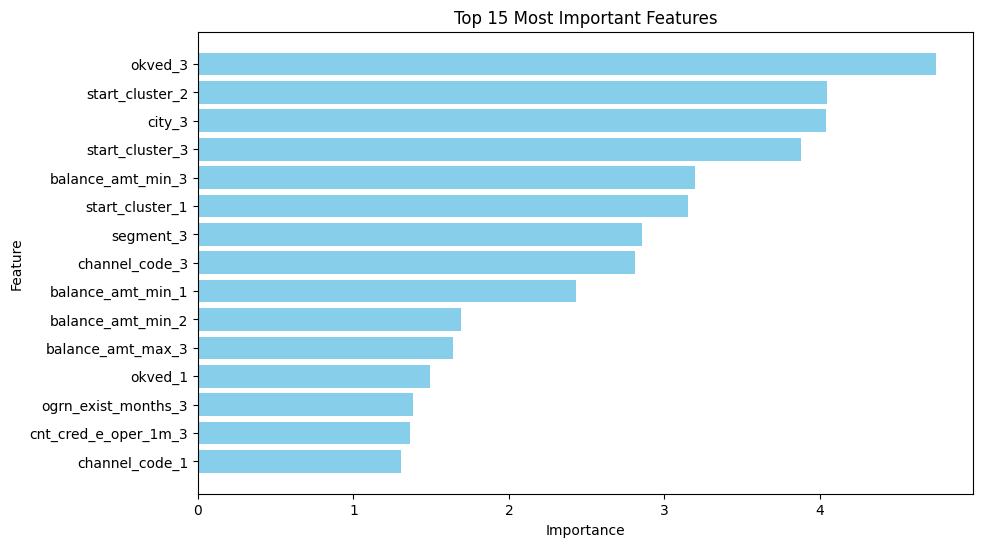

In [16]:
model.visualize_importances(15)

In [18]:
def make_submission():
    sample_submission_df = pd.read_csv(
        "sample_submission.csv"
    )

    test_pred_proba = model.predict_proba(test_df_pr)
    test_pred_proba_df = pd.DataFrame(
        test_pred_proba, columns=model.get_params()["classes"]
    )
    sorted_classes = sorted(test_pred_proba_df.columns.to_list())
    test_pred_proba_df = test_pred_proba_df[sorted_classes]

    sample_submission_df[sorted_classes] = test_pred_proba_df
    sample_submission_df.to_csv("tema.csv", index=False)

In [19]:
make_submission()